In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

**Resources - **
1. https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/
2. https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/
3. https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70
4. https://github.com/aravindpai/How-to-build-own-text-summarizer-using-deep-learning

In [6]:
summary = pd.read_csv('news_summary.csv', encoding='iso-8859-1')

In [7]:
raw = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [8]:
pre1 =  raw.iloc[:,0:2].copy()
# pre1['head + text'] = pre1['headlines'].str.cat(pre1['text'], sep =" ") 

pre2 = summary.iloc[:,0:6].copy()
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

In [9]:
pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'],pre2['headlines']],ignore_index = True)

In [10]:
len(pre)

102915

In [11]:
pre.head(2)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...


**Seq2Seq LSTM Modelling**
![final.jpg](attachment:final.jpg)

In [12]:
#LSTM with Attention
#pip install keras-self-attention

pre['text'][:10]



0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
5    Pakistani singer Rahat Fateh Ali Khan has deni...
6    India recorded their lowest ODI total in New Z...
7    Weeks after ex-CBI Director Alok Verma told th...
8    Andhra Pradesh CM N Chandrababu Naidu has said...
9    Congress candidate Shafia Zubair won the Ramga...
Name: text, dtype: object

> **Perform Data Cleansing**

In [13]:
import re

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row




In [14]:
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['summary'])

In [15]:
from time import time
import spacy
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:
#If data loss seems to be happening(i.e len(text) = 50 instead of 75 etc etc) in this cell , decrease the batch_size parametre 

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 4.03 mins


In [16]:
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:


t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.74 mins


In [17]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [18]:
summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [19]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

In [20]:
text_count = []
summary_count = []

In [21]:
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [22]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

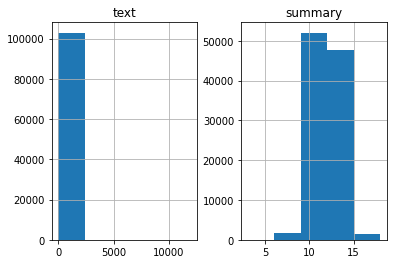

In [23]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [24]:
batch_size = 128
epochs = 10
embedding_dim = 200
latent_dim = 300
max_text_len=100
max_summary_len=15

In [25]:
#Check how much % of summary have 0-15 words
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.9978234465335472


In [26]:
#Check how much % of text have 0-70 words
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

0.9578389933440218


In [27]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [28]:
post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...


In [29]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')


In [30]:
post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...


**SEQ2SEQ MODEL BUILDING **

Split the data to TRAIN and VALIDATION sets

In [31]:
post_pre = post_pre[:41346] 

In [32]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [33]:
len(x_val)

4135

In [34]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

**RARE WORD ANALYSIS FOR X i.e 'text'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [35]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 58.504672897196265
Total Coverage of rare words: 2.1495300774883774


In [36]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 21757


**RARE WORD ANALYSIS FOR Y i.e 'summary'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [37]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [38]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 70.39303855441752
Total Coverage of rare words: 6.007990136393975


In [39]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 7112


We will now remove "Summary" i.e Y (both train and val) which has only _START_ and _END_

In [40]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [41]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [42]:
print(x_tr[0])
print(y_tr[0])

[ 2586     9     7    11  1313  8124     4   229  2369  2965   212  2004
     3  5558     5  1690     3   753  2173     8  6043     1   545   104
    84    27    11    17   177    29     2  3623     3  3677     8  3678
    92   212 15762  1547   808     3  5671   259  3678   488   106     9
    32  1313  8125    39   229  3678     3     1    38     3     1   769
   271     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
[   3    2 4393 4394    9 4146   90  640 1336 2406 1397    1    4    0
    0]


In [43]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")


print("Size of vocabulary from the w2v model = {}".format(x_voc))


Size of vocabulary from the w2v model = 21757


In [48]:
def seq2seq_lstm(max_text_len,embedding_dim,latent_dim,y_voc,x_voc,act_fun='softmax', 
                 optimizer='adam',loss = 'sparse_categorical_crossentropy',
                 dropout = 0.4, recurrent_dropout =  0.4): 

  K.clear_session()
  # Encoder
  encoder_inputs = Input(shape=(max_text_len,))

  #embedding layer
  enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

  #encoder lstm 1
  encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=dropout,recurrent_dropout=recurrent_dropout)
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

  #encoder lstm 2
  encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=dropout,recurrent_dropout=recurrent_dropout)
  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

  #encoder lstm 3
  encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=dropout,recurrent_dropout=recurrent_dropout)
  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))

  #embedding layer
  dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=dropout,recurrent_dropout=recurrent_dropout)
  decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

  #dense layer
  decoder_dense =  TimeDistributed(Dense(y_voc, activation=act_fun))
  decoder_outputs = decoder_dense(decoder_outputs)

  # Define the model 
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  model.compile(optimizer=optimizer, loss=loss)

  return model


In [49]:

model = seq2seq_lstm(max_text_len,embedding_dim,latent_dim,y_voc,x_voc)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     4351400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [50]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=epochs,callbacks=[es],batch_size=batch_size, 
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/10
291/291 [==============================] - 340s 1s/step - loss: 5.8971 - val_loss: 4.7876
Epoch 2/10
291/291 [==============================] - 330s 1s/step - loss: 4.7835 - val_loss: 4.6253
Epoch 3/10
291/291 [==============================] - 323s 1s/step - loss: 4.6275 - val_loss: 4.5010
Epoch 4/10
291/291 [==============================] - 314s 1s/step - loss: 4.4695 - val_loss: 4.3748
Epoch 5/10
291/291 [==============================] - 315s 1s/step - loss: 4.3053 - val_loss: 4.2727
Epoch 6/10
291/291 [==============================] - 314s 1s/step - loss: 4.1787 - val_loss: 4.1882
Epoch 7/10
291/291 [==============================] - 315s 1s/step - loss: 4.0623 - val_loss: 4.1110
Epoch 8/10
291/291 [==============================] - 316s 1s/step - loss: 3.9436 - val_loss: 4.0564
Epoch 9/10
291/291 [==============================] - 321s 1s/step - loss: 3.8515 - val_loss: 4.0191
Epoch 10/10
291/291 [==============================] - 324s 1s/step - loss: 3.7647 - val_lo

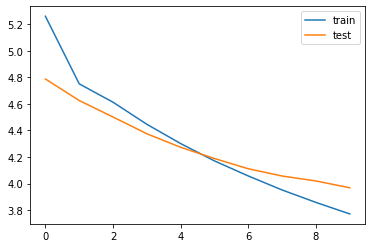

In [51]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [52]:
#!pip install keras-attention

In [53]:
from attention import AttentionLayer
# with seq2seq attention 
from keras import backend as K 

def seq2seq_attention(max_text_len,embedding_dim,latent_dim,y_voc,x_voc,act_fun='softmax', 
                 optimizer='adam',loss = 'sparse_categorical_crossentropy',
                 dropout = 0.4, recurrent_dropout =  0.4): 

  K.clear_session()

  # Encoder
  encoder_inputs = Input(shape=(max_text_len,))

  #embedding layer
  enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

  #encoder lstm 1
  encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=dropout,recurrent_dropout=recurrent_dropout)
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

  #encoder lstm 2
  encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=dropout,recurrent_dropout=recurrent_dropout)
  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

  #encoder lstm 3
  encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=dropout,recurrent_dropout=recurrent_dropout)
  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))

  #embedding layer
  dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=dropout,recurrent_dropout=recurrent_dropout)
  decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

  # Attention layer
  attn_layer = AttentionLayer(name='attention_layer')
  attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

  # Concat attention input and decoder LSTM output
  decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

  #dense layer
  decoder_dense =  TimeDistributed(Dense(y_voc, activation=act_fun))
  decoder_outputs = decoder_dense(decoder_concat_input)

  # Define the model 
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  
  model.compile(optimizer=optimizer, loss=loss)

  return  model 


In [54]:

model_attention = seq2seq_attention(max_text_len,embedding_dim,latent_dim,y_voc,x_voc)

model_attention.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     4351400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

**Start fitting the model with the data**

In [55]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

history_attention = model_attention.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                            epochs=epochs,callbacks=[es],batch_size=batch_size, 
                            validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/10
291/291 [==============================] - 350s 1s/step - loss: 5.7167 - val_loss: 4.7615
Epoch 2/10
291/291 [==============================] - 341s 1s/step - loss: 4.7257 - val_loss: 4.4422
Epoch 3/10
291/291 [==============================] - 340s 1s/step - loss: 4.3601 - val_loss: 4.0937
Epoch 4/10
291/291 [==============================] - 341s 1s/step - loss: 3.9702 - val_loss: 3.8451
Epoch 5/10
291/291 [==============================] - 333s 1s/step - loss: 3.6407 - val_loss: 3.6780
Epoch 6/10
291/291 [==============================] - 331s 1s/step - loss: 3.3859 - val_loss: 3.5591
Epoch 7/10
291/291 [==============================] - 328s 1s/step - loss: 3.1667 - val_loss: 3.4816
Epoch 8/10
291/291 [==============================] - 335s 1s/step - loss: 2.9816 - val_loss: 3.4334
Epoch 9/10
291/291 [==============================] - 332s 1s/step - loss: 2.8131 - val_loss: 3.3958
Epoch 10/10
291/291 [==============================] - 332s 1s/step - loss: 2.6639 - val_lo

**Visualize the model learning**

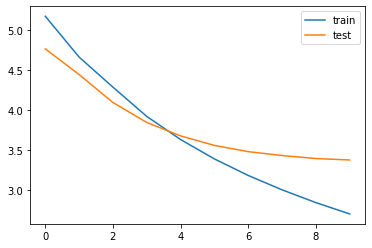

In [56]:
from matplotlib import pyplot
pyplot.plot(history_attention.history['loss'], label='train')
pyplot.plot(history_attention.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()